In [2]:
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime, date, time, timedelta
from dateutil import parser
from dateutil import rrule

from sklearn.metrics import auc, roc_curve, classification_report


%matplotlib inline
sns.set(style="white",context="talk")

# Summary
1. **Data selection**: Use only the **control group** in the second part(analyzing key drivers) because the “test” will contaminate the result
2. **Metrics selection**: Consider using **normalized metrics** (revenue per day/number of users) => to **account for the fact that the unit of diversion is different (not 50%/50%)**

# Goal
1. Should the company sell its software for $39 or $59? => **A/B Test result interpretation**
2. What are your main findings looking at the data? => **actionable insights to increase conversion rate**
3. After how many days you would have stopped the test? Please, explain why.=> minimum days = minimum test sample / (traffic* diversion ratio)

# 1. Loading Data

In [3]:
# Load the conversion project dataset
user = pd.read_csv("user_table.csv", sep = ",")
test = pd.read_csv("test_results.csv", sep = ",")

In [4]:
print(f'user table consists of {user.shape[0]} rows and {user.shape[1]} cols')
user.head()

user table consists of 275616 rows and 5 cols


,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [5]:
print(f'test table consists of {test.shape[0]} rows and {test.shape[1]} cols')
test.head()

test table consists of 316800 rows and 8 cols


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [6]:
print(f"The new customer journey consists of {user.shape[0]} rows and {user.shape[1]} columns, with 0 missing values\n")
pd.DataFrame({"data_types":user.dtypes, 
          "value_counts": user.nunique(),
          "null_counts": user.isnull().sum()}).set_index(user.dtypes.index)

The new customer journey consists of 275616 rows and 5 columns, with 0 missing values



,data_types,value_counts,null_counts
user_id,int64,275616,0
city,object,923,0
country,object,1,0
lat,float64,713,0
long,float64,830,0


In [7]:
print(f"The new customer journey consists of {test.shape[0]} rows and {test.shape[1]} columns, with 0 missing values\n")
pd.DataFrame({"data_types":test.dtypes, 
          "value_counts": test.nunique(),
          "null_counts": test.isnull().sum()}).set_index(test.dtypes.index)

The new customer journey consists of 316800 rows and 8 columns, with 0 missing values



,data_types,value_counts,null_counts
user_id,int64,316800,0
timestamp,object,140931,0
source,object,12,0
device,object,2,0
operative_system,object,6,0
test,int64,2,0
price,int64,2,0
converted,int64,2,0


since there are some user whose information are not recorded, I would focus on the test table exclusively when analyzing the A/B Test result

In [8]:
# Next, let's take a look at the descriptive statistics
print("For numeric variables: \n",test.describe(),"\n")
print("For categorical variables: \n", test.describe(include = "object"))

For numeric variables: 
               user_id           test          price      converted
count   316800.000000  316800.000000  316800.000000  316800.000000
mean    499281.341840       0.360079      46.205051       0.018333
std     288591.154044       0.480024       9.601487       0.134154
min          3.000000       0.000000      39.000000       0.000000
25%     249525.750000       0.000000      39.000000       0.000000
50%     499021.500000       0.000000      39.000000       0.000000
75%     749025.500000       1.000000      59.000000       0.000000
max    1000000.000000       1.000000      59.000000       1.000000 

For categorical variables: 
                   timestamp          source  device operative_system
count                316800          316800  316800           316800
unique               140931              12       2                6
top     2015-04-12 11:51:16  direct_traffic  mobile          windows
freq                     12           60357  186471           100

### Date

In [10]:
# Since the a/b test is a 5-day timeframe experiment, here I include a dayofweek column
test["timestamp"] = list(map(lambda x: datetime.fromisoformat(x),test['timestamp'].replace(":60",":59", regex=True)))

# Date
test["date"] =  list(map(lambda day:day.date(), test.timestamp))

# Weekday
wkday_dict = {1:"Mon",2:"Tue",3:"Wed",4:"Thu",5:"Fri",6:"Sat",7:"Sun"}
test['weekday'] = list(map(lambda x: wkday_dict[x], 
                           pd.Series(map(lambda x: x.date().weekday() + 1,
                                        test['timestamp']))))

# Week_of_month (assuming 4 weeks in a month)
def get_week(day):
    if 1<= day.day < 8:
        return "first_week"
    elif 8<= day.day < 15:
        return "second_week"
    elif 15<= day.day < 22:
        return "third_week"
    else:
        return "last_week"
test["week"] = list(map(lambda day: get_week(day), test.timestamp))

# Month
month_dict = {3:"Mar",4:"Apr",5:"May"}
test["month"] = list(map(lambda day:month_dict[day.month], test.timestamp))

test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,date,weekday,week,month
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Fri,second_week,May
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Sun,second_week,May
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Sat,first_week,Apr
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Thu,first_week,May
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Sun,last_week,May


# 2. Result Analysis

### 2-1. Sanity Check
Unit of diversion being random (invariant metrics being the population diverted by each timeframe, source, device, and OS

In [14]:
test.groupby("operative_system").test.mean().reset_index().sort_values(by="test")

,operative_system,test
3,mac,0.347578
1,iOS,0.352066
4,other,0.352135
0,android,0.356642
5,windows,0.370236
2,linux,0.466264


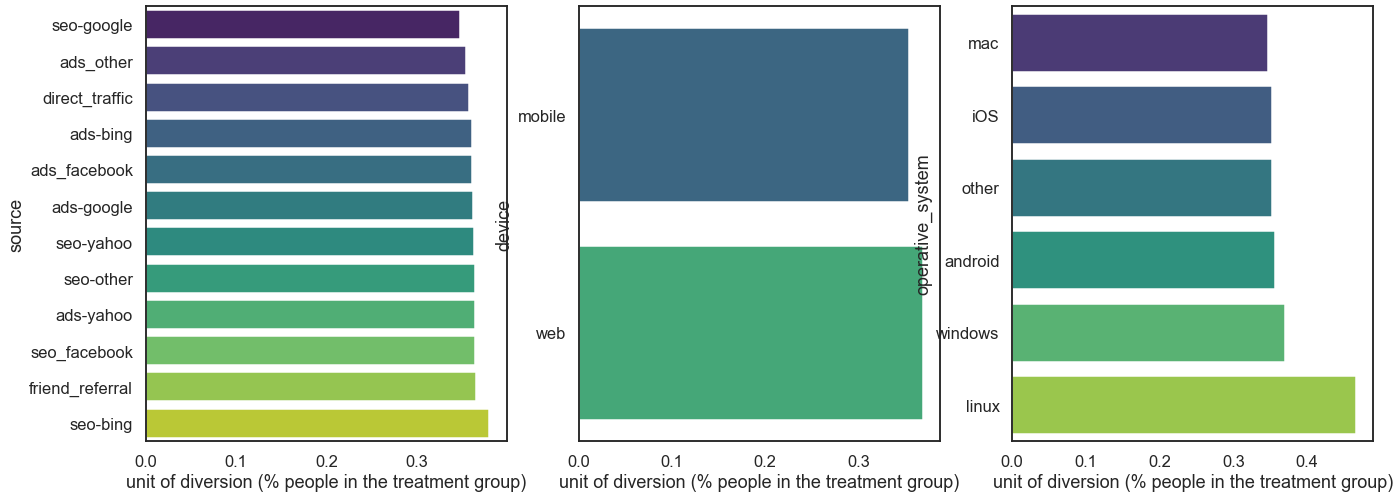

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 8))

sns.barplot(y = "source",x = "test",data = test.groupby("source").test.mean().reset_index().sort_values(by="test"), ax = axes[0],
            palette=sns.color_palette("viridis",12))
axes[0].set_xlabel("unit of diversion (% people in the treatment group)")

sns.barplot(y = "device",x = "test",data = test.groupby("device").test.mean().reset_index().sort_values(by="test"), ax = axes[1],
           palette=sns.color_palette("viridis",2))
axes[1].set_xlabel("unit of diversion (% people in the treatment group)")

sns.barplot(y = "operative_system",x = "test",data = test.groupby("operative_system").test.mean().reset_index().sort_values(by="test"),
            ax = axes[2],palette=sns.color_palette("viridis"))
axes[2].set_xlabel("unit of diversion (% people in the treatment group)")

plt.show()

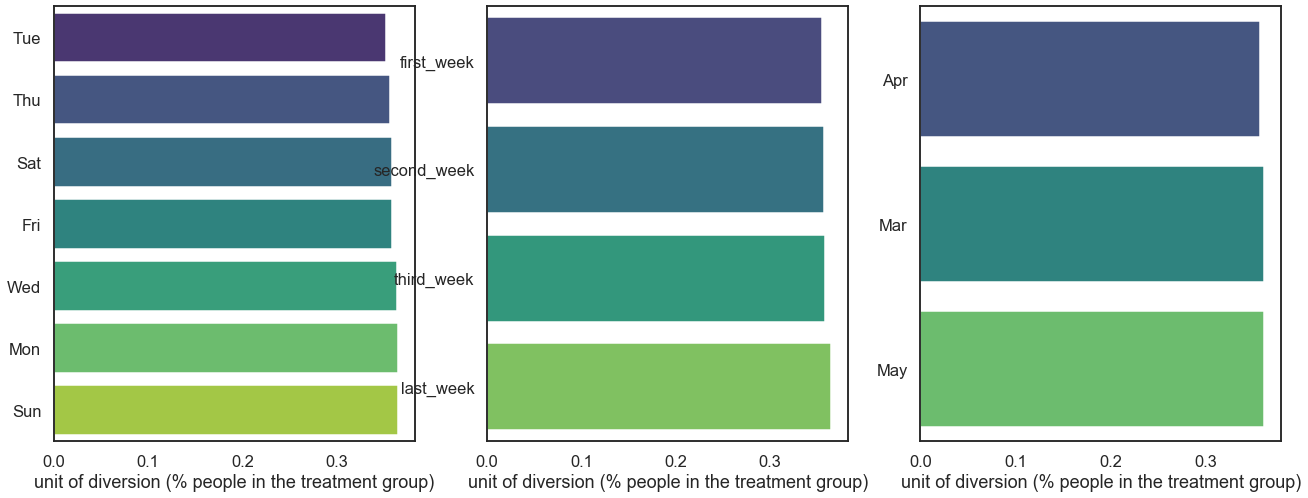

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 8))

sns.barplot(y = "weekday",x = "test",data = test.groupby("weekday").test.mean().reset_index().sort_values(by="test"), ax = axes[0],
            palette=sns.color_palette("viridis",7))
axes[0].set_xlabel("unit of diversion (% people in the treatment group)")
axes[0].set_ylabel("")

sns.barplot(y = "week",x = "test",data = test.groupby("week").test.mean().reset_index().sort_values(by="test"), ax = axes[1],
           palette=sns.color_palette("viridis",4))
axes[1].set_xlabel("unit of diversion (% people in the treatment group)")
axes[1].set_ylabel("")

sns.barplot(y = "month",x = "test",data = test.groupby("month").test.mean().reset_index().sort_values(by="test"),
            ax = axes[2],palette=sns.color_palette("viridis",3))
axes[2].set_xlabel("unit of diversion (% people in the treatment group)")
axes[2].set_ylabel("")

plt.show()

The unit of diversion by operating system might not be random => check if the difference is statistically significant

In [17]:
from scipy import stats
# equality of variance
#mac_test = test[test.operative_system == "mac"].groupby("date")["test"].mean().values
#iOS_test = test[test.operative_system == "iOS"].groupby("date")["test"].mean().values
#other_test = test[test.operative_system == "other"].groupby("date")["test"].mean().values
#android_test = test[test.operative_system == "android"].groupby("date")["test"].mean().values
#windows_test = test[test.operative_system == "windows"].groupby("date")["test"].mean().values
#linux_test = test[test.operative_system == "linux"].groupby("date")["test"].mean().values

#args=[mac_test, iOS_test, other_test, android_test, windows_test, linux_test]
#w,p = stats.levene(*args)
#w,p

In [18]:
def anova_test(df, col, target_col):
    '''
    Assumption:
    df has date column
    
    df: test dataframe (pandas df)
    col: the column to be tested (string)
    '''
    args = []
    for value in df[col].unique():
        args.append(df[df[col] == value].groupby("date")[target_col].mean().values)
    f, p = stats.f_oneway(*args)

    print(f'For {col}: One-way ANOVA')
    print(f"Number of pairs of samples: {len(args[0])}")
    print('=============')

    print('F value:', round(f,4))
    print('P value:', round(p,4))
    

In [19]:
anova_test(test,"operative_system","test")

For operative_system: One-way ANOVA
Number of pairs of samples: 91
F value: 23.8286
P value: 0.0


In [20]:
anova_test(test,"source","test")

For source: One-way ANOVA
Number of pairs of samples: 91
F value: 1.08
P value: 0.3739


In [21]:
anova_test(test,"device","test")

For device: One-way ANOVA
Number of pairs of samples: 91
F value: 17.7583
P value: 0.0


In [22]:
anova_test(test,"week","test")

For week: One-way ANOVA
Number of pairs of samples: 21
F value: 1.3017
P value: 0.2791


In [23]:
anova_test(test,"month","test")

For month: One-way ANOVA
Number of pairs of samples: 31
F value: 0.5863
P value: 0.5585


In [24]:
anova_test(test,"weekday","test")

For weekday: One-way ANOVA
Number of pairs of samples: 13
F value: 0.7169
P value: 0.637


### 2.2 Test Result Interpretation

Since price increasing is almost doomed to lower the conversion rate, our target metrics should be **revenue per day**. But here I still include the conversion rate as our counter metrics to learn more about how user responds to a price increase from 39 to 59

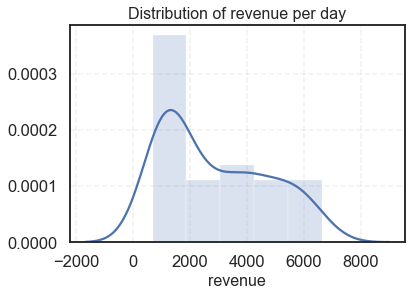

In [27]:
hist_kws={'histtype': 'bar', 'alpha': 0.2}
test["revenue"] = 0
test.loc[test.test == 1,"revenue"] = test.converted*59
test.loc[test.test == 0,"revenue"] = test.converted*39

sns.distplot(test.groupby("date")['revenue'].sum(),hist_kws=hist_kws)

plt.title('Distribution of revenue per day', fontsize=16)
plt.xlabel('revenue',fontsize = 16)
plt.grid(linestyle="--", alpha=0.3)

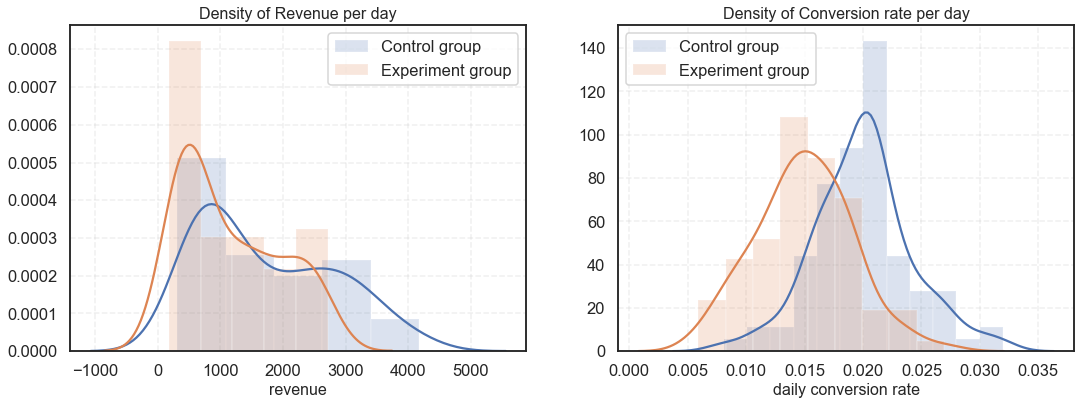

In [28]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
sns.distplot(test[test['test'] == 0].groupby("date")['revenue'].sum(),
             label='Control group', ax=axes[0], hist_kws=hist_kws)
sns.distplot(test[test['test'] == 1].groupby("date")['revenue'].sum(), 
             label='Experiment group', ax=axes[0], hist_kws=hist_kws)

axes[0].set_title('Density of Revenue per day', fontsize=16)
axes[0].set_xlabel('revenue',fontsize = 16)
axes[0].legend()
axes[0].grid(linestyle="--", alpha=0.3)

sns.distplot(test[test['test'] == 0].groupby("date")['converted'].mean(),
             label='Control group', ax=axes[1], hist_kws=hist_kws)
sns.distplot(test[test['test'] == 1].groupby("date")['converted'].mean(), 
             label='Experiment group', ax=axes[1], hist_kws=hist_kws)
axes[1].set_title('Density of Conversion rate per day', fontsize=16)
axes[1].set_xlabel('daily conversion rate',fontsize = 16)
axes[1].legend()
axes[1].grid(linestyle="--", alpha=0.3)

In [29]:
exp_group = test[test.test == 1]
ctr_group = test[test.test == 0]

exp_mean_conv = exp_group.groupby("date")["converted"].mean()
ctr_mean_conv = ctr_group.groupby("date")["converted"].mean()

exp_revenue_per_day = exp_group.groupby("date")["revenue"].sum()
ctr_revenue_per_day = ctr_group.groupby("date")["revenue"].sum()

# Define some basic variables
SIZE_EXP = len(exp_group)
SIZE_CTR = len(ctr_group)
date_axis = test.date.unique().tolist()
print(f"The size of the treatment group is {SIZE_EXP}, the size of the control group is {SIZE_CTR}")
print(f"The A/B Test lasts for {(max(date_axis) - min(date_axis)).days} days, starting from {min(date_axis)} to {max(date_axis)}")
print(f"Average conversion rate for the experiment group:{round(exp_group.converted.mean(),4)}; \
Average conversion rate for the control group:{round(ctr_group.converted.mean(),4)}")
print(f"Average revenue per day for the experiment group:{round(exp_revenue_per_day.mean(),4)}; \
Average conversion rate for the control group:{round(ctr_revenue_per_day.mean(),4)}")

The size of the treatment group is 114073, the size of the control group is 202727
The A/B Test lasts for 90 days, starting from 2015-03-02 to 2015-05-31
Average conversion rate for the experiment group:0.0155; Average conversion rate for the control group:0.0199
Average revenue per day for the experiment group:1149.5275; Average conversion rate for the control group:1729.2857


It is a bit interesting in the sense that both the overall conversion rate and revenue per day in the experiment group is actually lower than the control group.\
Now let's take a look at whether the difference is actually statistically significant

In [38]:
def levene_t_test(data1, data2):
    print("Data1: KS-Test",stats.kstest(data1, 'norm'))
    print("Data1: KS-Test",stats.kstest(data2, 'norm'),"\n")
    t,p = stats.levene(data1,data2)
    print(f"Levene variance test: t={round(t,3)}, p={round(p,3)}")
    if p<0.05:
        print("----variances of the two group are not equal----")
        t,p = stats.ttest_ind(data1,data2, equal_var = False)
    else:
        t,p = stats.ttest_ind(data1,data2)
    print(f"Independent t-test: t={round(t,3)}, p={round(p,4)}")

In [40]:
print("For daily conversion rate:")
print(stats.ttest_rel(
    exp_mean_conv.values,
    ctr_mean_conv.values))

print("\nFor revenue per day:")
print(stats.ttest_rel(
    exp_revenue_per_day.values,
    ctr_revenue_per_day.values))

For daily conversion rate:
Ttest_relResult(statistic=-8.49704801260082, pvalue=3.822203451625515e-13)

For revenue per day:
Ttest_relResult(statistic=-12.157219309195465, pvalue=1.0854211174426415e-20)


Well, the p-values for these two metrics are very close to 0 and t-statistics is negative. Therefore, we are over 99% confident to reject the null hypothesis that the price increasing option have no influence on current revenue and conversion rate. However, since it imposes a negative impact on our revenue, it is not a good option for now

**Customers are very sensitive towards a price increase from 39 to 59. People stop buying and the increase of revenue per order fails to make up the reduction in quantity**

# 3. Findings
Which factors that could possiblity drive the conversion rate?

In [41]:
data = test

In [42]:
test.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,date,weekday,week,month,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Fri,second_week,May,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Sun,second_week,May,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Sat,first_week,Apr,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Thu,first_week,May,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Sun,last_week,May,0


In [185]:
# Correlation with the target variable
pd.get_dummies(test.drop(["user_id", "timestamp", "test","price","date"],axis = 1)).corr()["converted"].sort_values()[:10]

source_direct_traffic      -0.021782
operative_system_android   -0.014109
source_ads-bing            -0.013213
source_ads_other           -0.009559
operative_system_other     -0.009300
operative_system_linux     -0.008667
operative_system_windows   -0.007030
source_seo_facebook        -0.004591
source_ads-yahoo           -0.004160
source_seo-other           -0.003459
Name: converted, dtype: float64

### 3-1. Source
1. Ads: reallocate resources from ads-bing and ads-others towards ads-yahoo
2. SEO: reallocate resources towards seo-bing
3. frend-referral: give bonus on friends referral

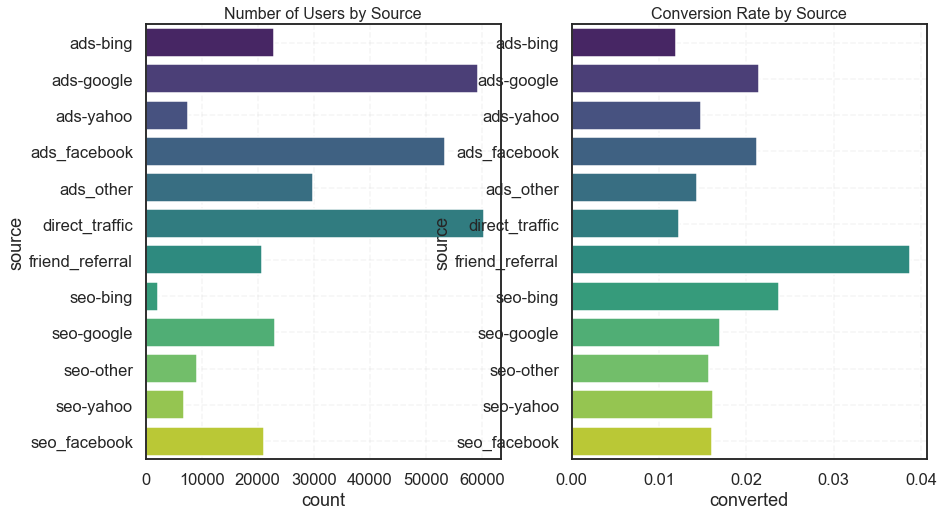

In [193]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(y='source', data=data.sort_values(by = "source"),ax=axes[0],palette=sns.color_palette("viridis",12))
axes[0].set_title('Number of Users by Source', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='source', x='converted', data=data.sort_values(by = "source"),ci=0,ax=axes[1],palette=sns.color_palette("viridis",12))
axes[1].set_title('Conversion Rate by Source', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [202]:
anova_test(test,"source","converted")

For source: One-way ANOVA
Number of pairs of samples: 91
F value: 6.2739
P value: 0.0


### 3-2. OS
1. App: everything looks good
2. PC: shift from windows, linux, others to mac

In [48]:
data.groupby("operative_system").agg({"user_id":"count","converted":"mean"})

,user_id,converted
operative_system,,
android,74935,0.014933
iOS,95465,0.022322
linux,4135,0.008222
mac,25085,0.023998
other,16204,0.012960
windows,100976,0.016955


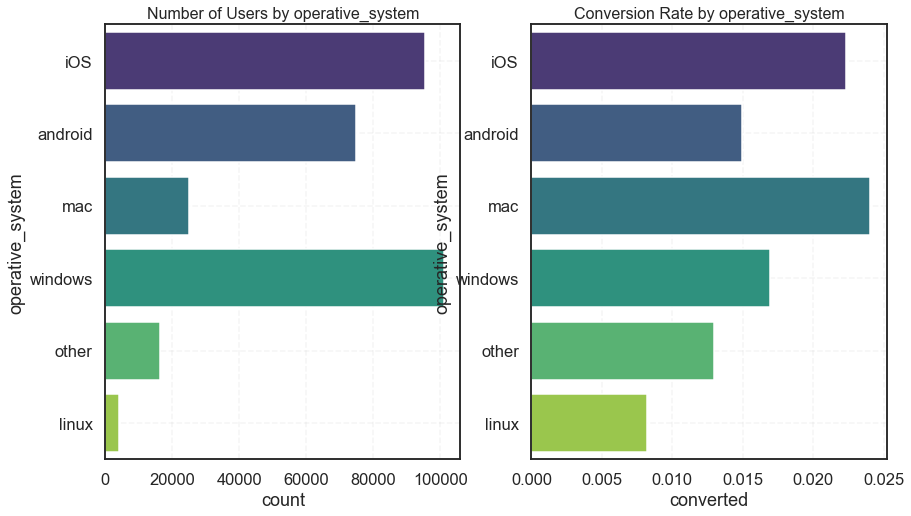

In [194]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(y='operative_system', data=data,ax=axes[0],palette=sns.color_palette("viridis", 6))
axes[0].set_title('Number of Users by operative_system', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='operative_system', x='converted', data=data,ci=0,ax=axes[1],palette=sns.color_palette("viridis", 6))
axes[1].set_title('Conversion Rate by operative_system', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [204]:
anova_test(test,"operative_system","converted")

For operative_system: One-way ANOVA
Number of pairs of samples: 91
F value: 27.7974
P value: 0.0


### 3-3. Device
Focus more on mobile rather than App (10% significance level)

In [54]:
data.groupby("operative_system").converted.mean()

operative_system
android    0.014933
iOS        0.022322
linux      0.008222
mac        0.023998
other      0.012960
windows    0.016955
Name: converted, dtype: float64

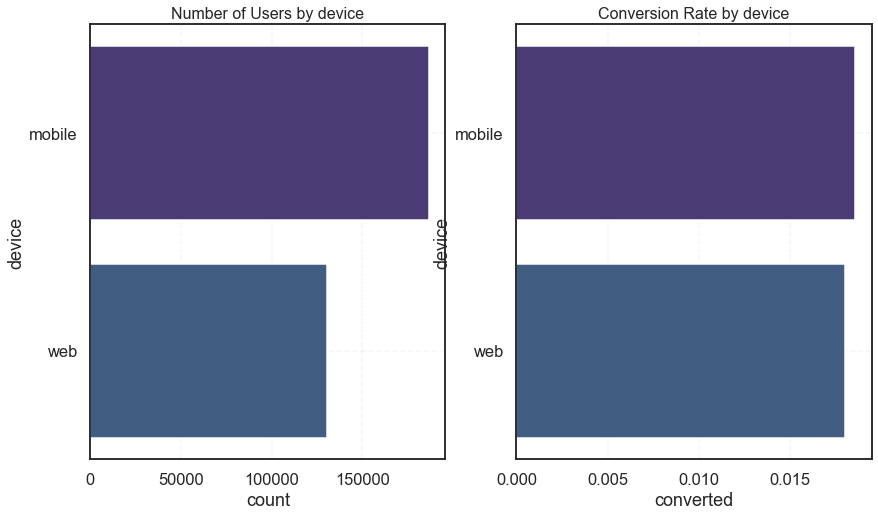

In [198]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(y='device', data=data.sort_values(by = "device"),ax=axes[0],palette=sns.color_palette("viridis"))
axes[0].set_title('Number of Users by device', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='device', x='converted', data=data.sort_values(by = "device"),ci=0,ax=axes[1],palette=sns.color_palette("viridis"))
axes[1].set_title('Conversion Rate by device', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [205]:
anova_test(test,"device","converted")

For device: One-way ANOVA
Number of pairs of samples: 91
F value: 2.8616
P value: 0.0924


### 3-4. Weekday
Difference in conversion rate among groups is not significant

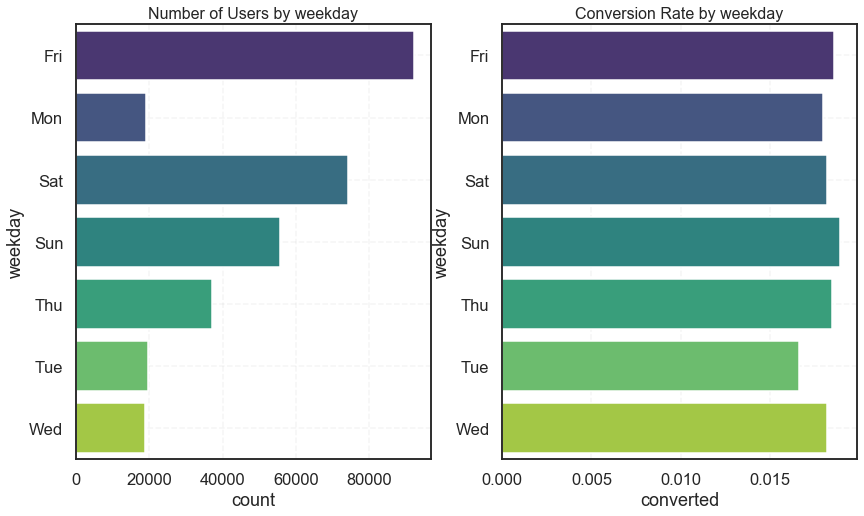

In [199]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(y='weekday', data=data.sort_values(by = "weekday"),ax=axes[0],palette=sns.color_palette("viridis", 7))
axes[0].set_title('Number of Users by weekday', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='weekday', x='converted', data=data.sort_values(by = "weekday"),ci=0,ax=axes[1],palette=sns.color_palette("viridis", 7))
axes[1].set_title('Conversion Rate by weekday', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [211]:
anova_test(test,"weekday","converted")

For weekday: One-way ANOVA
Number of pairs of samples: 13
F value: 0.5986
P value: 0.7307


### 3-5. Week
Difference in conversion rate among groups is not significant

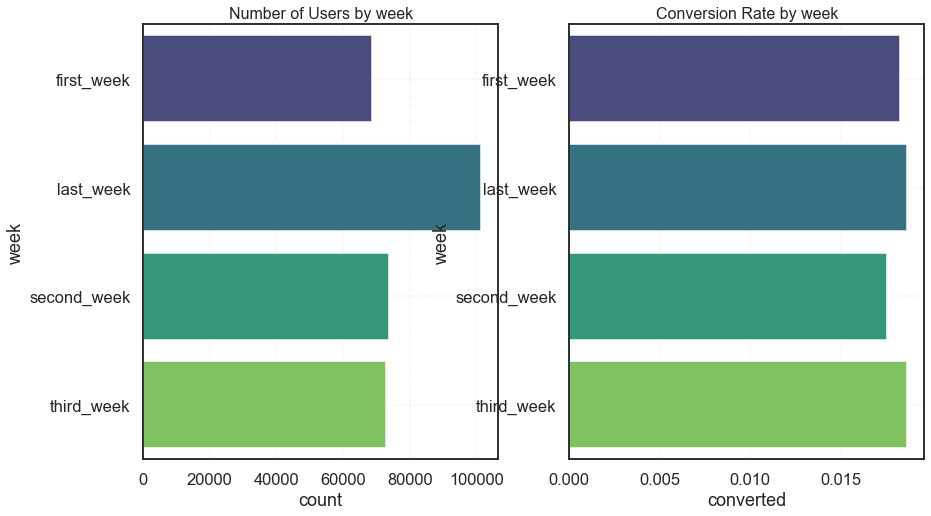

In [200]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(y='week', data=data.sort_values(by = "week"),ax=axes[0],palette=sns.color_palette("viridis", 4))
axes[0].set_title('Number of Users by week', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='week', x='converted', data=data.sort_values(by = "week"),ci=0,ax=axes[1],palette=sns.color_palette("viridis", 4))
axes[1].set_title('Conversion Rate by week', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [210]:
anova_test(test,"week","converted")

For week: One-way ANOVA
Number of pairs of samples: 21
F value: 0.4616
P value: 0.7098


### 3-6. Month
Difference in conversion rate among groups is not significant

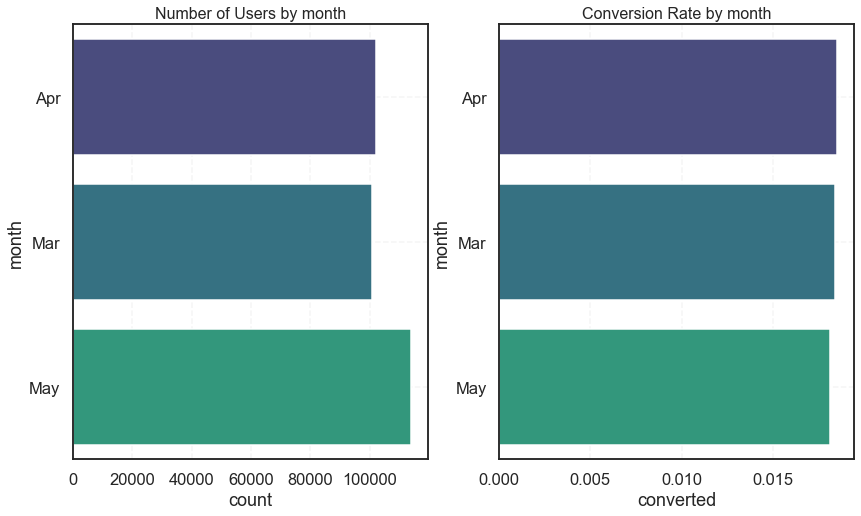

In [201]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.countplot(y='month', data=data.sort_values(by = "month"),ax=axes[0],palette=sns.color_palette("viridis", 4))
axes[0].set_title('Number of Users by month', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='month', x='converted', data=data.sort_values(by = "month"),ci=0,ax=axes[1],palette=sns.color_palette("viridis", 4))
axes[1].set_title('Conversion Rate by month', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [237]:
anova_test(data,"month","converted")

For month: One-way ANOVA
Number of pairs of samples: 31
F value: 0.4843
P value: 0.6177


### 3-7. City
We focus on city level because all the users are from the same country

In [49]:
data2 = pd.merge(left = data, right = user, how = "inner", on = "user_id")
data2.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,date,weekday,week,month,revenue,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,2015-05-08,Fri,second_week,May,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0,2015-05-10,Sun,second_week,May,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0,2015-04-04,Sat,first_week,Apr,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,2015-05-07,Thu,first_week,May,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,2015-05-24,Sun,last_week,May,0,Fishers,USA,39.95,-86.02


In [62]:
city_data = data2.groupby("city").agg({"user_id":"count","converted":"mean"}).reset_index().sort_values(by = "converted",ascending =False)
city_data.columns = ["city","num_users","conversion"]
city_data[:10]

,city,num_users,conversion
561,North Atlanta,5,0.200000
135,Catonsville,26,0.153846
708,Saint Charles,7,0.142857
611,Parkway-South Sacramento,17,0.117647
280,Findlay,9,0.111111
77,Blue Springs,21,0.095238
81,Bonita Springs,11,0.090909
447,Lehigh Acres,46,0.086957
613,Parsippany-Troy Hills Township,37,0.081081
801,Sun City,89,0.078652


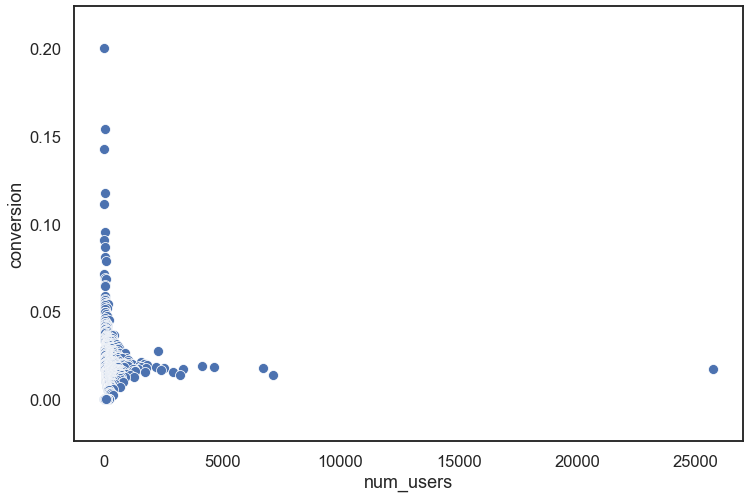

In [77]:
fig = plt.figure(figsize = (12,8))
sns.scatterplot(x="num_users",y="conversion",data = city_data,s=100)
plt.show()

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 8))
sns.barplot(y='city', x='converted', data=data.sort_values(by = "city"),ci=0,ax=axes[1],palette=sns.color_palette("viridis", 4))
axes[0].set_title('Number of Users by city', fontsize=16)
axes[0].grid(linestyle="--", alpha=0.2)

sns.barplot(y='city', x='converted', data=data.sort_values(by = "city"),ci=0,ax=axes[1],palette=sns.color_palette("viridis", 4))
axes[1].set_title('Conversion Rate by city', fontsize=16)
axes[1].grid(linestyle="--", alpha=0.2)

#fig.suptitle("", fontsize = 16)
plt.show()

In [52]:
data2.to_excel("06.pricing_test_result.xlsx",index= False)

# 4. Sample Size and Testing Period

### 4-1. Conversion 
Set a = 5%, 1-β = 80%, baseline conversion = 1.55%, minimum detectable effect = 1% (absolute)
**It is safe to stop now**. As the total traffic per variation has already exceeded the minimum requirement

In [265]:
print(f"Current size per variation: {len(data[data.test == 1])}")

Current size per variation: 114073


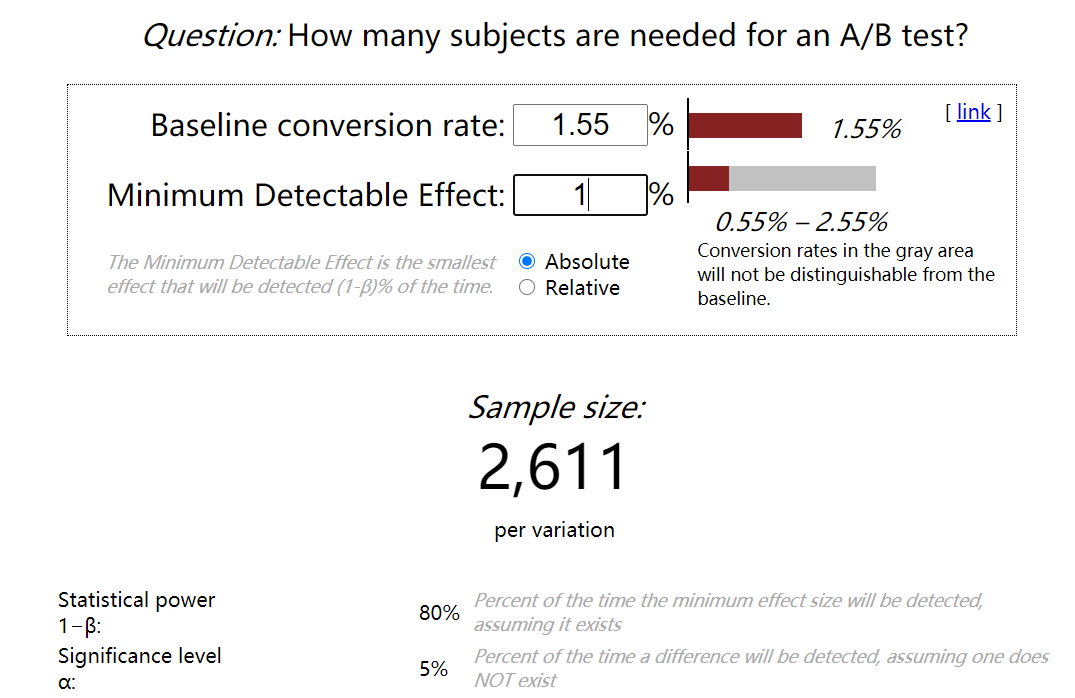

### 4-2. Revenue per day
Set a = 5%, 1-β = 80% (go for z-test..)

In [255]:
print("Data1: KS-Test",stats.kstest(data.groupby("date").revenue.sum().values, 'norm'))

Data1: KS-Test KstestResult(statistic=1.0, pvalue=0.0)


In [262]:
from scipy.stats import norm
def sampleSize_twoGroups(D, alpha=0.05, beta=0.2, sigma1=1, sigma2=1):
    '''Sample size for two groups. The formula corresponds to Eq 6.4 in the book.'''
     
    n = np.round((norm.ppf(1-alpha/2.) + norm.ppf(1-beta))**2 * (sigma1**2 + sigma2**2) / D**2)
     
    print(('In order to detect a change of {0} between groups with an SD of {1} and {2},'.format(D, sigma1, sigma2)))
    print(('with significance {0} and test-power {1}, you need in each group at least {2:d} subjects.'.format(alpha, 100*(1-beta), int(n))))
     
    return n

sampleSize_twoGroups((ctr_revenue_per_day.mean() - exp_revenue_per_day.mean()),
                    0.05,
                    0.2,
                    sigma1 = ctr_revenue_per_day.std(),
                   sigma2 = exp_revenue_per_day.std())

In order to detect a change of 579.7582417582416 between groups with an SD of 1075.1121004674014 and 797.087968666213,
with significance 0.05 and test-power 80.0, you need in each group at least 42 subjects.


42.0